# MILDNet Inference code

In [109]:
# import libraries
import os
import glob
from natsort import natsorted
import argparse
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## Dataset creation 

In [110]:
# creating custom dataset, here we craeted example dataset for MRI dataset

class MRIDataset(Dataset):
    def __init__(self, path, split):
        self.path = path
        self.split = split


        self.images = natsorted(glob.glob(os.path.join(self.path,  self.split, 'images/*')))
        self.masks = natsorted(glob.glob(os.path.join(self.path, self.split, 'masks/*')))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        self.to_tensor = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize((256, 256)),
                                             transforms.ToTensor(), ])

        self.image = cv2.imread(self.images[index], 1)
        self.image = self.to_tensor(self.image)

        self.mask = cv2.imread(self.masks[index], 0)
        self.mask = self.to_tensor(self.mask)



        return self.image, self.mask


## Load the dataset and dataloader

In [111]:
# dataset and dataloader
test_dataset = MRIDataset(path='data/MRI', split='valid')
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1,num_workers=0)

## Visualize sample images and ground truth masks

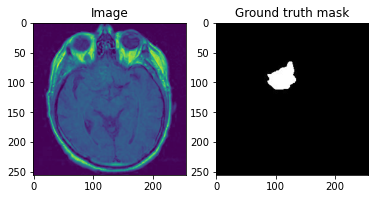

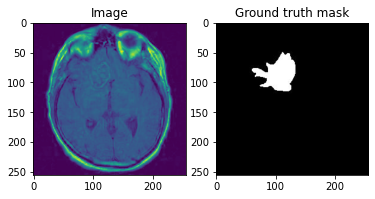

In [112]:
# display sample image and it's corresponding mask
for i, (image, mask) in enumerate(test_dataset):
    #print(image.shape, mask.shape)
    
    image = image.numpy().transpose(1, 2, 0)
    image = image[:, :, 0]
    
    mask = mask.numpy().transpose(1,2,0)
    mask = mask[:, :, 0]
    
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Image')
    
    plt.subplot(122)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground truth mask')
    
    plt.show()
    
    if i==1:
        break

## Set the device 

In [113]:
# set the devide to GPU is available.
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## load the trained model 

In [114]:
# load best saved checkpoint
## please repalce the architecturte name to predict the results on another baseline approaches
### Avaialble modles ['unet', 'unet++', 'residual', 'resdunet', 'multires', 'mild'] 


model = torch.load('main_results/MRI/models/unet.pth', map_location=torch.device('cpu')).to(device)

In [115]:
# IOU metrics 

def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x
    
def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union

## Predictions on the test dataset

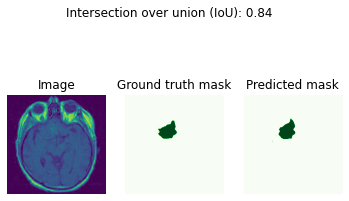

-------------------------------------------------


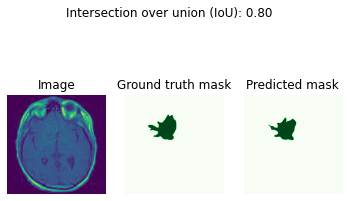

-------------------------------------------------


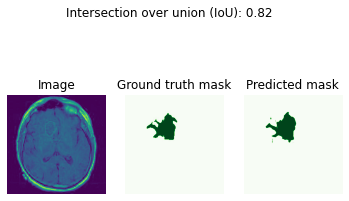

-------------------------------------------------


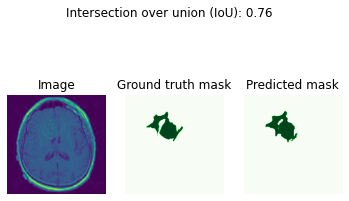

-------------------------------------------------


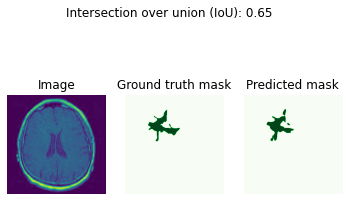

-------------------------------------------------


In [116]:
for i, (image, gt_mask_tensor) in enumerate(test_dataloader):
    #print(image.shape, gt_mask.shape)
    
    
    image = image.cuda()
    pred_mask_tensor = model.module.predict(image)
    

    image = image[0].cpu().numpy().transpose(1, 2, 0)
    image = image[:, :, 0]
    
    gt_mask = gt_mask_tensor[0].cpu().detach().numpy().transpose(1, 2, 0)
    gt_mask = gt_mask[:, :, 0]
    
    pred_mask = pred_mask_tensor[0].cpu().detach().numpy().transpose(1, 2, 0)
    pred_mask = pred_mask[:, :, 0]
    
    plt.subplot(131)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Image')
    
    plt.subplot(132)
    plt.imshow(gt_mask, cmap='Greens')
    plt.axis('off')
    plt.title('Ground truth mask')
    
    plt.subplot(133)
    plt.imshow(pred_mask, cmap='Greens')
    plt.axis('off')
    plt.title('Predicted mask')
    
    plt.suptitle('Intersection over union (IoU): {:.2f}'.format(iou(pred_mask_tensor.cpu(), gt_mask_tensor).item()))
    plt.show()
    
    print('-------------------------------------------------')
    
    

    
    if i==4:
        break